# Define Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import scipy
import numpy as np
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.model_selection import train_test_split
import collections

In [2]:
from torch import nn

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),            
            nn.Linear(32, 7),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [3]:
device = 'cpu'

model = Net().to(device)
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=7, bias=True)
  )
)


# Load Data

In [4]:
import pandas as pd
tweet=pd.read_csv('UriTweetsZipcode.csv')
tweet_grouped = tweet.groupby('damagedZipCode')
loss = pd.read_csv('WinterStormData.csv')
loss_grouped = loss.groupby('damagedZipCode')
loss_list = [
'ihpAmount',
'haAmount',
'onaAmount',
'rpfvl',
'ppfvl',
'rentalAssistanceAmount' ,
'repairAmount' 
]

C:\Users\piyalong\venvs\tamids\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (1,2,5,6,8,9,10,12,13,14,15,16,18,21,29,47,50,70,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
len(loss)

414392

In [6]:
len(loss_grouped)

1587

In [7]:
len(tweet_grouped)

550

In [8]:
txtdata={}
for name, group in tweet_grouped:
    if len(name)!=5:continue
    name=int(name)
    if name in txtdata.keys():
        txtdata.append({name:group['text']})
    else:
        txtdata.update({name:group['text']})
        # print("append")
        

In [9]:
len(txtdata)

535

In [10]:

loss_data={}
distri = {}
# overlap={}
for name, group in loss_grouped:
    name=int(name)
#     if name in intersection:
#         overlap.update
    if group[loss_list].mean().mean()==0:continue
    # if len(group)==1:continue

    distri.update({name:len(group)})
    loss_data.update({name:group[loss_list]})
    

In [11]:
intersection = list(set(loss_data.keys())&set(txtdata.keys()))

# loss_data={}
# distri = {}
overlap={}
for name, group in loss_grouped:
    name=int(name)
    if name in intersection:
        overlap.update
#     if group[loss_list].mean().mean()==0:continue
    # if len(group)==1:continue

#     distri.update({name:len(group)})
#     loss_data.update({name:group[loss_list]})
    

In [12]:
len(loss_data)

1345

In [13]:
np.argmax(np.count_nonzero(loss[loss_list], axis=0))

0

In [16]:
counter=collections.Counter(distri)


In [18]:
paired_data={}
overlapping={}
for name in intersection:

    paired_data.update({name:[loss_data[name].mean(),txtdata[name]]})
    overlapping.update({name:loss_data[name]["ihpAmount"].mean()})

In [19]:
len(paired_data)

338

In [20]:
pd.DataFrame([overlapping]).T.to_csv("overlapping damage.csv")

In [23]:

X=[]
y=[]

for k,v in paired_data.items():

    y.append(v[0])
    text=v[1].str.cat()
    # create the transform
    vectorizer=HashingVectorizer(n_features=1024)
    vector = vectorizer.transform([text])
    # vector = nlp(text)
    matrix=vector.A
    list_desnse=matrix.tolist()
    X.append(list_desnse)

# Prepare all social media data for testing

In [25]:
all_social_media = []

for k,v in txtdata.items():

    text=v.str.cat()
    # create the transform
    vectorizer=HashingVectorizer(n_features=1024)
    vector = vectorizer.transform([text])
    matrix=vector.A
    list_desnse=matrix.tolist()
    all_social_media.append(list_desnse)

# Split data for traning

In [26]:

    
X,y=np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).float())


In [27]:
X_train.shape

torch.Size([270, 1, 1024])

In [28]:
X_test.shape

torch.Size([68, 1, 1024])

# Train Model

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.L1Loss()
criterion = criterion.to(device)


In [34]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

loses={'train':[],'test':[]}
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
model.apply(weight_reset)

patience=100
counter=0
early_stop=False
for epoch in range(10000):
    y_pred = model(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
#     if epoch % 100 == 0:

    y_test_pred = model(X_test)
    y_test_pred = torch.squeeze(y_test_pred)
    test_loss = criterion(y_test_pred, y_test)

    loses['train'].append(train_loss.detach().numpy())
    loses['test'].append(test_loss.detach().numpy())

    if test_loss>train_loss:
        counter+=1

    if counter >= patience:
        early_stop = True

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if early_stop:
        torch.save(model.state_dict(), 'test2.pth')
        break

In [35]:
test_loss.detach().numpy()

array(126.17783, dtype=float32)

In [36]:
loses['test'][-1]

array(126.17783, dtype=float32)

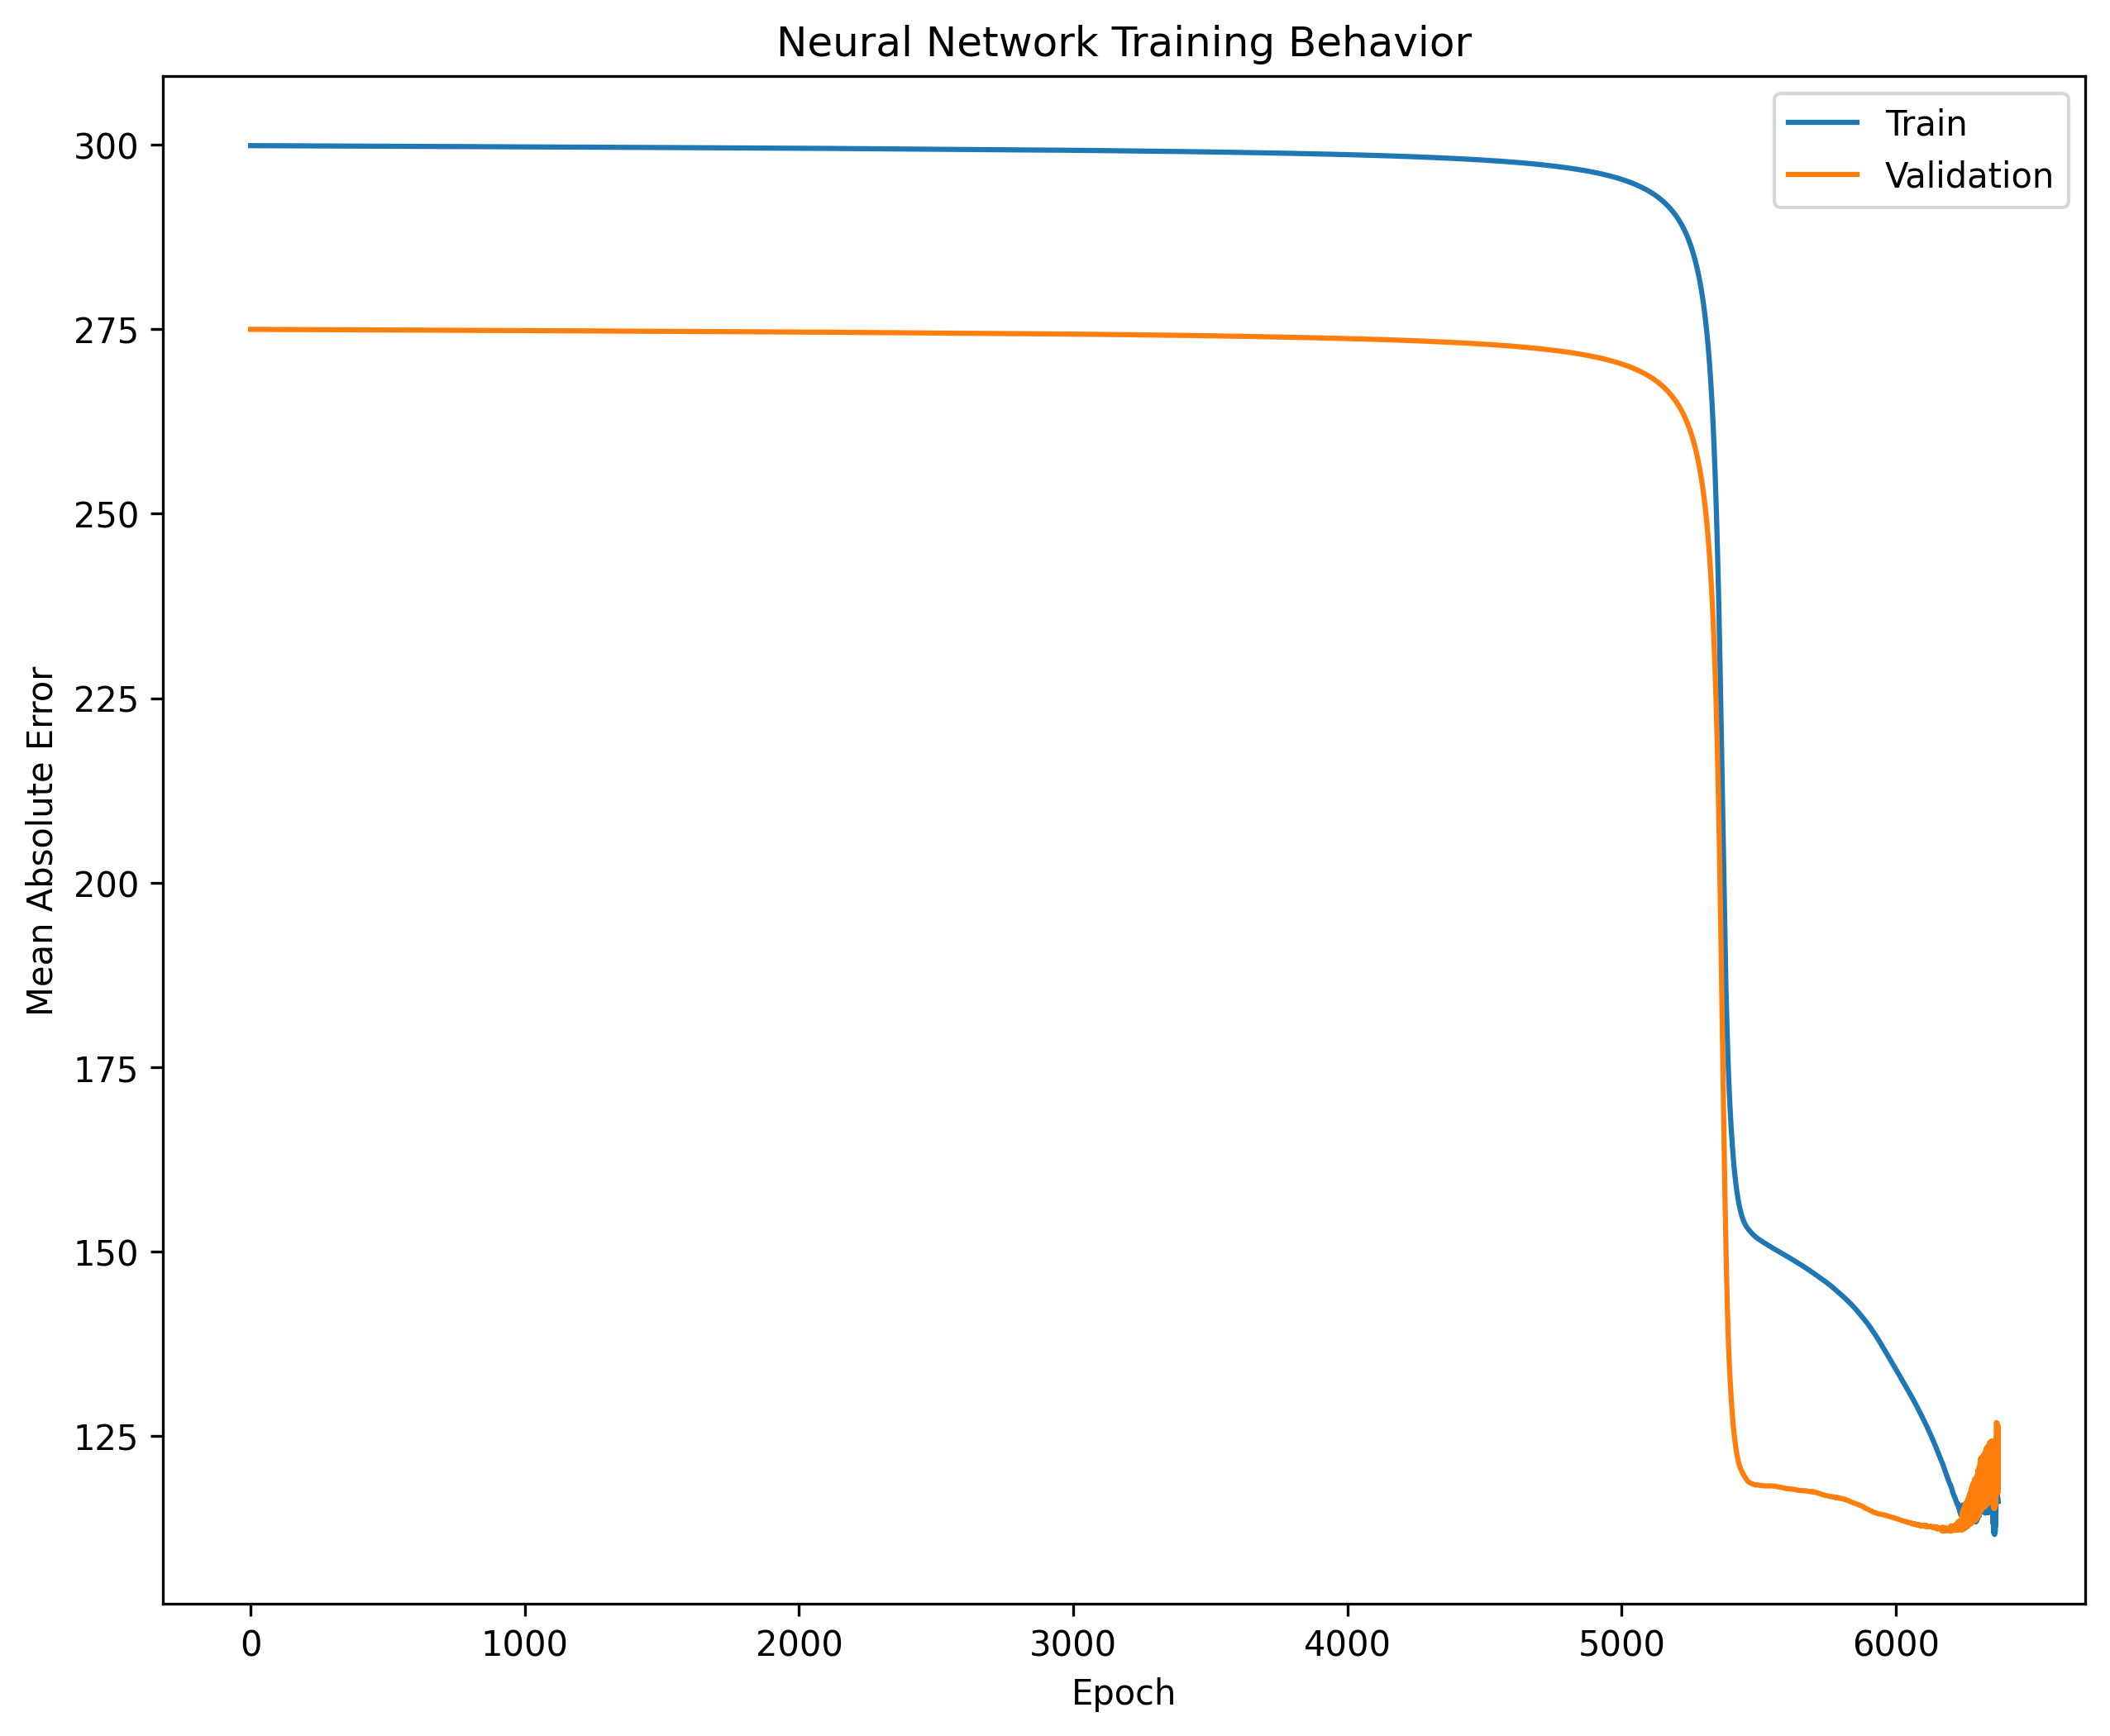

In [37]:
plt.figure(figsize=(10,8),dpi=300)
plt.title('Neural Network Training Behavior')
plt.plot(loses['train'],label='Train')
plt.plot(loses['test'],label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.savefig('Training2.png')

# Load trained model

In [38]:
model.load_state_dict(torch.load('test2.pth'))
model.eval()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [39]:
X_test.shape

torch.Size([68, 1, 1024])

In [40]:
np.array(all_social_media).shape

(535, 1, 1024)

In [41]:
tensor = torch.from_numpy(np.array(all_social_media).astype("float32"))

In [42]:
y_pre=model(tensor).detach().numpy()

In [43]:
pd.DataFrame(zip(txtdata.keys(),[y[0] for y in y_pre])).to_csv("ihp Prediction based on all social media data for mapping 2.csv")

In [44]:
y_pre=model(X_test).detach().numpy()
y_gt=y_test.detach().numpy()

In [45]:
from sklearn.metrics import mean_absolute_error

In [46]:
y_pre.T.shape

(7, 68)

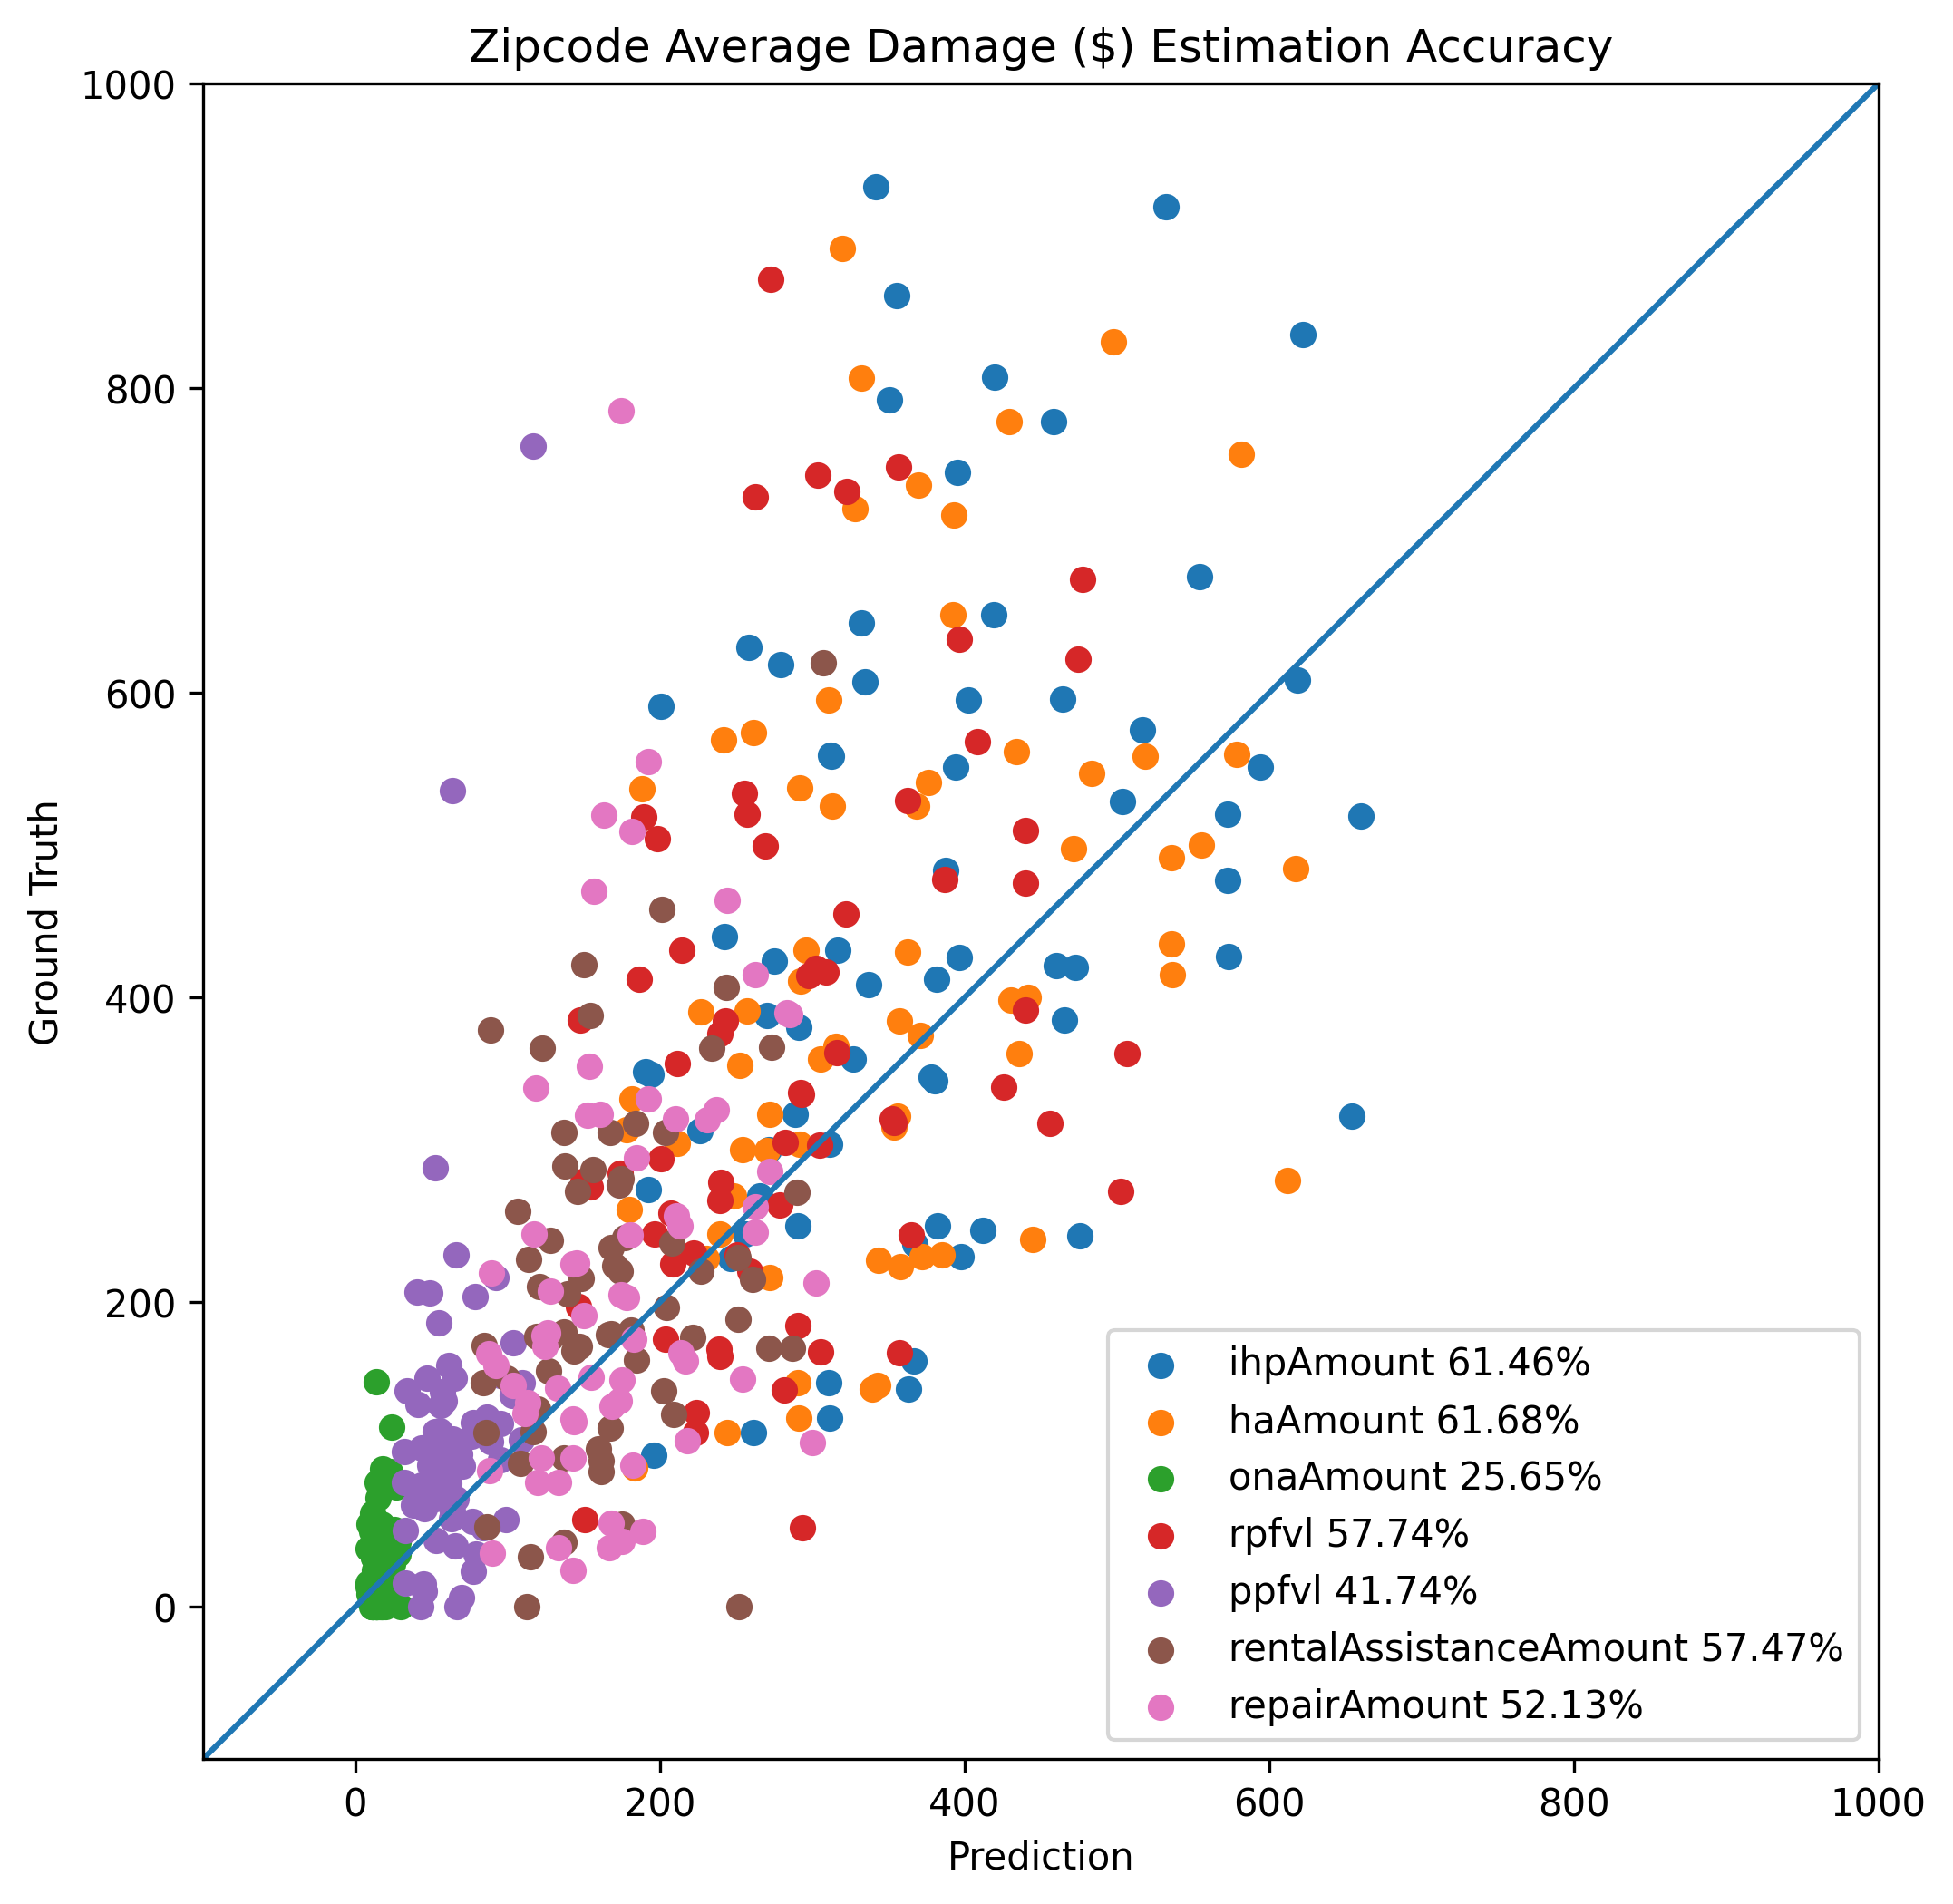

In [47]:
plt.figure(figsize=(8,8),dpi=300)
plt.axes(aspect='equal')
plt.title('Zipcode Average Damage ($) Estimation Accuracy')
for pre,gt,name in zip (y_pre.T,y_gt.T,loss_list):
    mae=mean_absolute_error(pre,gt)
    p = 1- mae/np.mean(gt)
    plt.scatter(pre,gt,label=name+' '+str(round(p*100,2))+'%')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.legend()
lims = [-100, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig('Average Damage Estimation Accuracy2.png')

In [48]:
from sklearn.metrics import mean_absolute_error

In [49]:
mean_absolute_error(model(X_test).detach().numpy(),y_test.detach().numpy())/y_test.detach().numpy().mean()

0.42634833

In [50]:
mean_absolute_error(model(X_test).detach().numpy(),y_test.detach().numpy())

117.23226